In [1]:
import re
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [2]:
%matplotlib inline 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.io as pio

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [3]:
car_df = pd.read_csv("car_evaluation.csv", index_col= None, header=None)
car_df.shape

(1728, 7)

In [4]:
car_df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
coln_map = dict({0:"Price",
                 1:"Maintenance",
                 2:"NumDoors",
                 3:"NumPersons",
                 4:"LugBoot",
                 5:"Safety",
                 6:"Class"})
car_df.rename(columns = coln_map, inplace=True)

In [6]:
car_df.head()

,Price,Maintenance,NumDoors,NumPersons,LugBoot,Safety,Class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


#### Column Nomenclature

1. **Price** - Buying price
2. **Maintenance** - Cost of maintenance
3. **NumDoors** - Number of doors
4. **NumPersons** - Capacity of the car (in terms of the number of people it can carry)
5. **LugBoot** - Size of the luggage boot
6. **Safety** - Estimated safety of the car

In [7]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Price        1728 non-null   object
 1   Maintenance  1728 non-null   object
 2   NumDoors     1728 non-null   object
 3   NumPersons   1728 non-null   object
 4   LugBoot      1728 non-null   object
 5   Safety       1728 non-null   object
 6   Class        1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [8]:
car_df.Price.value_counts()

vhigh    432
med      432
low      432
high     432
Name: Price, dtype: int64

In [9]:
car_df.Maintenance.value_counts()

vhigh    432
med      432
low      432
high     432
Name: Maintenance, dtype: int64

In [10]:
car_df.NumDoors.value_counts()

2        432
4        432
5more    432
3        432
Name: NumDoors, dtype: int64

In [11]:
car_df.NumPersons.value_counts()

2       576
4       576
more    576
Name: NumPersons, dtype: int64

In [12]:
car_df.LugBoot.value_counts()

small    576
med      576
big      576
Name: LugBoot, dtype: int64

In [13]:
car_df.Safety.value_counts()

med     576
low     576
high    576
Name: Safety, dtype: int64

In [14]:
car_df.Class.value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: Class, dtype: int64

In [15]:
class_frac = car_df.Class.value_counts()/len(car_df.Class)

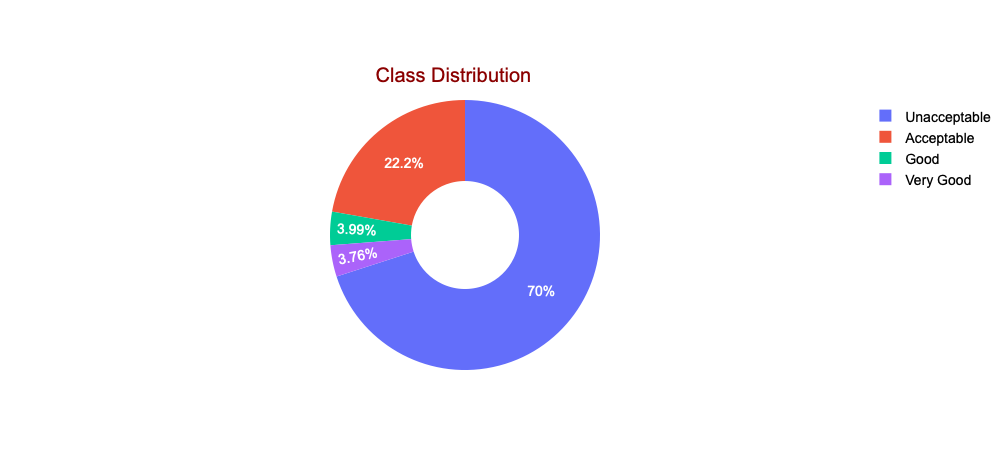

In [16]:
fg = go.Figure(layout=go.Layout(height=450, width=600))

fg.add_trace(go.Pie(values=class_frac,
                    labels=["Unacceptable", "Acceptable", "Good", "Very Good"],
                    hole=0.4,
                    insidetextfont=dict(family="Arial", size=14, color="white"),
#                     pull=[0, 0.04]
                     ))
fg.update_layout(title_text = 'Class Distribution',
                 title_font = dict(size=20, family='Arial', color='darkred'),
                 title_x=0.45,
                 title_y=0.85,
                 legend = dict(font = dict(family = "Arial", size = 14, color = "black")))

fg.show()

In [17]:
['#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a', '#fdca26', '#f0f921']

['#0d0887',
 '#46039f',
 '#7201a8',
 '#9c179e',
 '#bd3786',
 '#d8576b',
 '#ed7953',
 '#fb9f3a',
 '#fdca26',
 '#f0f921']

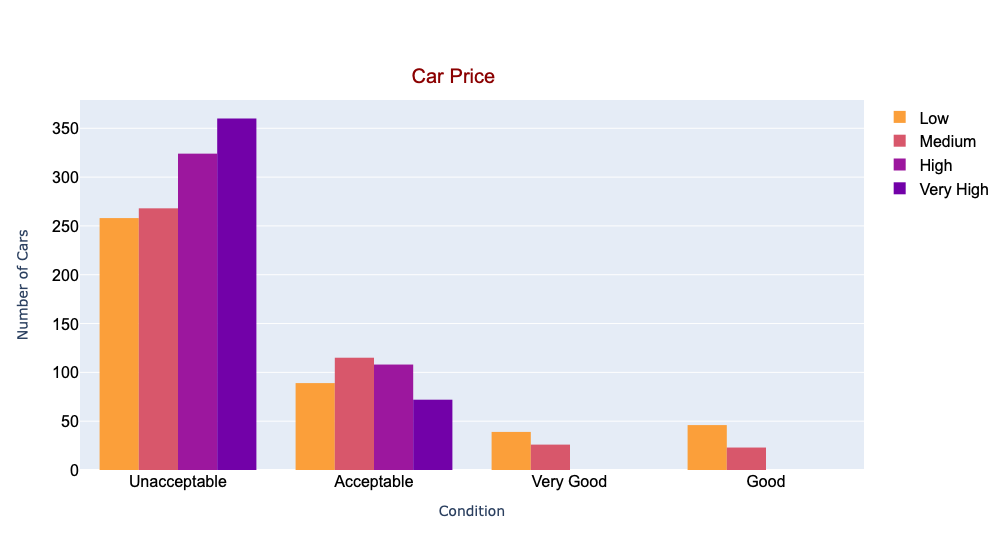

In [18]:
fg3 = go.Figure(layout=go.Layout(height=550, width=800))

fg3.add_trace(go.Histogram(x=car_df.loc[car_df.Price=="low", "Class"],
                           name = "Low",
                           marker=dict(color="#fb9f3a")))
fg3.add_trace(go.Histogram(x=car_df.loc[car_df.Price=="med", "Class"],
                           name = "Medium",
                           marker=dict(color="#d8576b")))
fg3.add_trace(go.Histogram(x=car_df.loc[car_df.Price=="high", "Class"],
                           name = "High",
                           marker=dict(color="#9c179e")))
fg3.add_trace(go.Histogram(x=car_df.loc[car_df.Price=="vhigh", "Class"],
                           name = "Very High",
                           marker=dict(color="#7201a8")))

fg3.update_xaxes(title_text="Condition", 
                 showticklabels=True, 
                 tickmode="array",
                 tickvals=["unacc", "acc", "good", "vgood"],
                 ticktext=["Unacceptable", "Acceptable", "Good", "Very Good"],
                 tickfont=dict(family="Arial", size=16, color="black"))

fg3.update_yaxes(title_text="Number of Cars", tickfont=dict(family="Arial", size=16, color="black"))

fg3.update_layout(legend = dict(font = dict(family = "Arial", size = 16, color="black")),
                  title_text = 'Car Price',
                  title_font = dict(size=20, family='Arial', color='darkred'),
                  title_x=0.45,
                  title_y=0.875)

fg3.show()

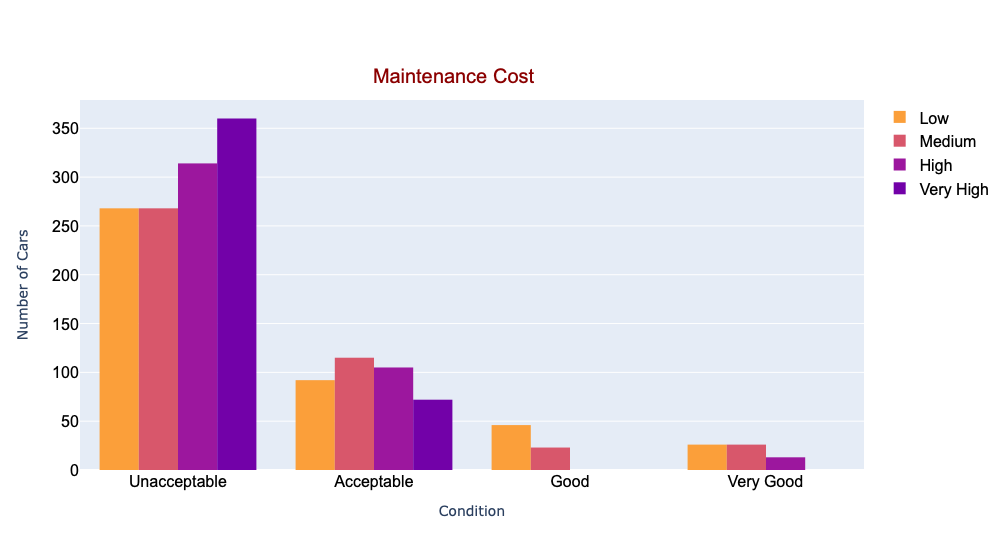

In [19]:
fg1 = go.Figure(layout=go.Layout(height=550, width=800))

fg1.add_trace(go.Histogram(x=car_df.loc[car_df.Maintenance=="low", "Class"],
                           name = "Low",
                           marker=dict(color="#fb9f3a")))
fg1.add_trace(go.Histogram(x=car_df.loc[car_df.Maintenance=="med", "Class"],
                           name = "Medium",
                           marker=dict(color="#d8576b")))
fg1.add_trace(go.Histogram(x=car_df.loc[car_df.Maintenance=="high", "Class"],
                           name = "High",
                           marker=dict(color="#9c179e")))
fg1.add_trace(go.Histogram(x=car_df.loc[car_df.Maintenance=="vhigh", "Class"],
                           name = "Very High",
                           marker=dict(color="#7201a8")))

fg1.update_xaxes(title_text="Condition", 
                 showticklabels=True, 
                 tickmode="array",
                 tickvals=["unacc", "acc", "good", "vgood"],
                 ticktext=["Unacceptable", "Acceptable", "Good", "Very Good"],
                 tickfont=dict(family="Arial", size=16, color="black"))

fg1.update_yaxes(title_text="Number of Cars", tickfont=dict(family="Arial", size=16, color="black"))

fg1.update_layout(legend = dict(font = dict(family = "Arial", size = 16, color="black")),
                  title_text = 'Maintenance Cost',
                  title_font = dict(size=20, family='Arial', color='darkred'),
                  title_x=0.45,
                  title_y=0.875)

fg1.show()

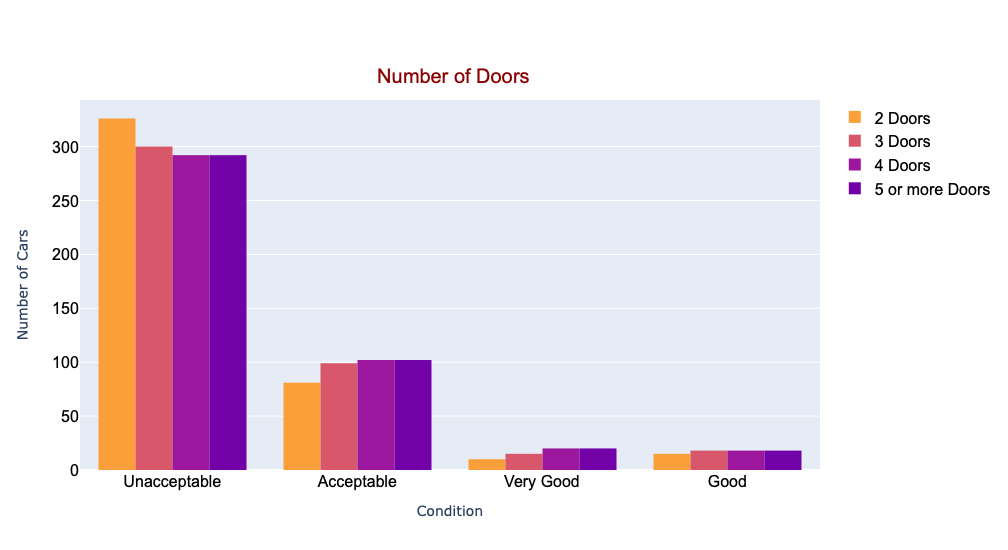

In [20]:
fg = go.Figure(layout=go.Layout(height=550, width=800))

fg.add_trace(go.Histogram(x=car_df.loc[car_df.NumDoors=="2", "Class"],
                           name = "2 Doors",
                           marker=dict(color="#fb9f3a")))
fg.add_trace(go.Histogram(x=car_df.loc[car_df.NumDoors=="3", "Class"],
                           name = "3 Doors",
                           marker=dict(color="#d8576b")))
fg.add_trace(go.Histogram(x=car_df.loc[car_df.NumDoors=="4", "Class"],
                           name = "4 Doors",
                           marker=dict(color="#9c179e")))
fg.add_trace(go.Histogram(x=car_df.loc[car_df.NumDoors=="5more", "Class"],
                           name = "5 or more Doors",
                           marker=dict(color="#7201a8")))

fg.update_xaxes(title_text="Condition", 
                 showticklabels=True, 
                 tickmode="array",
                 tickvals=["unacc", "acc", "good", "vgood"],
                 ticktext=["Unacceptable", "Acceptable", "Good", "Very Good"],
                 tickfont=dict(family="Arial", size=16, color="black"))

fg.update_yaxes(title_text="Number of Cars", tickfont=dict(family="Arial", size=16, color="black"))

fg.update_layout(legend = dict(font = dict(family = "Arial", size = 16, color="black")),
                 title_text = 'Number of Doors',
                 title_font = dict(size=20, family='Arial', color='darkred'),
                 title_x=0.45,
                 title_y=0.875)

fg.show()

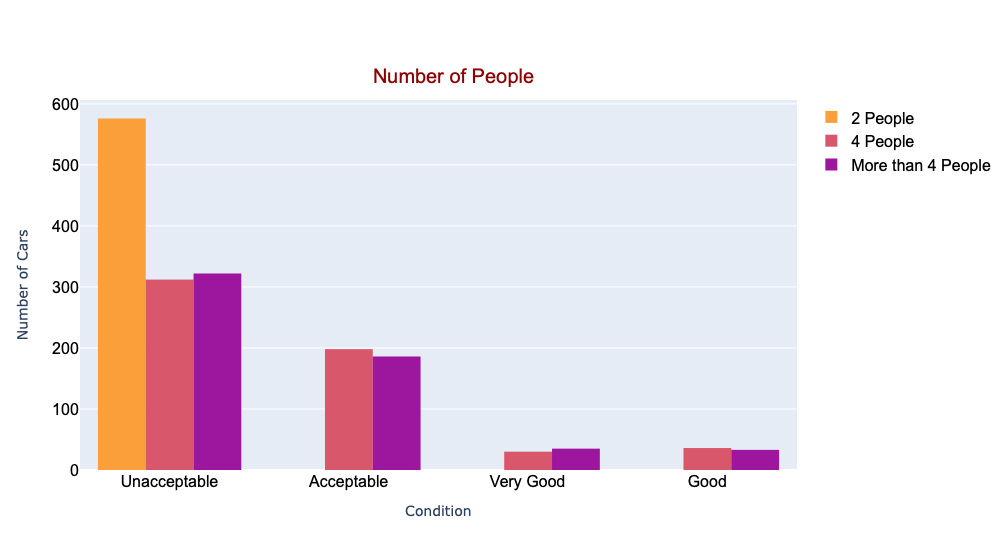

In [21]:
fg2 = go.Figure(layout=go.Layout(height=550, width=800))

fg2.add_trace(go.Histogram(x=car_df.loc[car_df.NumPersons=="2", "Class"],
                           name = "2 People",
                           marker=dict(color="#fb9f3a")))
fg2.add_trace(go.Histogram(x=car_df.loc[car_df.NumPersons=="4", "Class"],
                           name = "4 People",
                           marker=dict(color="#d8576b")))
fg2.add_trace(go.Histogram(x=car_df.loc[car_df.NumPersons=="more", "Class"],
                           name = "More than 4 People",
                           marker=dict(color="#9c179e")))

fg2.update_xaxes(title_text="Condition", 
                 showticklabels=True, 
                 tickmode="array",
                 tickvals=["unacc", "acc", "good", "vgood"],
                 ticktext=["Unacceptable", "Acceptable", "Good", "Very Good"],
                 tickfont=dict(family="Arial", size=16, color="black"))

fg2.update_yaxes(title_text="Number of Cars", tickfont=dict(family="Arial", size=16, color="black"))

fg2.update_layout(legend = dict(font = dict(family = "Arial", size = 16, color="black")),
                  title_text = 'Number of People',
                  title_font = dict(size=20, family='Arial', color='darkred'),
                  title_x=0.45,
                  title_y=0.875)

fg2.show()

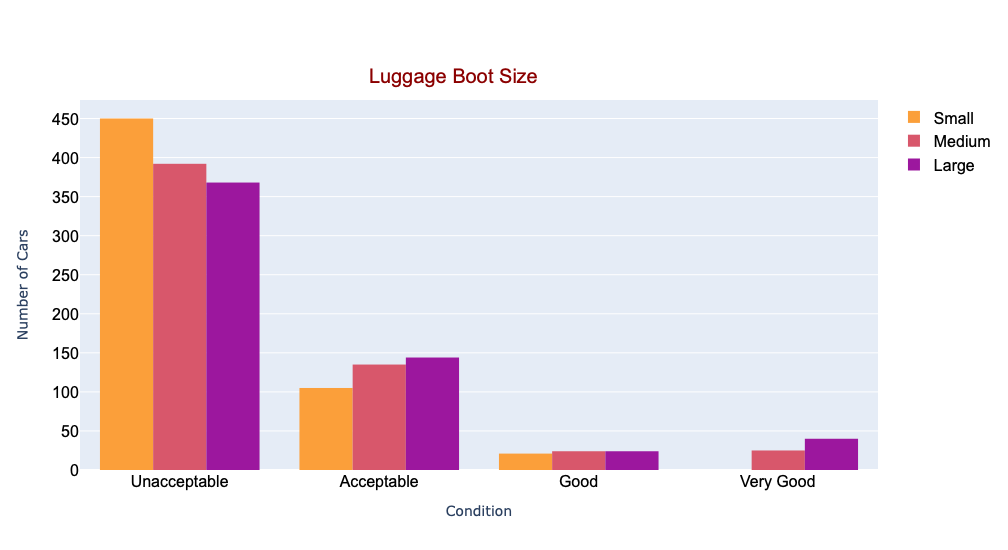

In [22]:
fg4 = go.Figure(layout=go.Layout(height=550, width=800))

fg4.add_trace(go.Histogram(x=car_df.loc[car_df.LugBoot=="small", "Class"],
                           name = "Small",
                           marker=dict(color="#fb9f3a")))
fg4.add_trace(go.Histogram(x=car_df.loc[car_df.LugBoot=="med", "Class"],
                           name = "Medium",
                           marker=dict(color="#d8576b")))
fg4.add_trace(go.Histogram(x=car_df.loc[car_df.LugBoot=="big", "Class"],
                           name = "Large",
                           marker=dict(color="#9c179e")))

fg4.update_xaxes(title_text="Condition", 
                 showticklabels=True, 
                 tickmode="array",
                 tickvals=["unacc", "acc", "good", "vgood"],
                 ticktext=["Unacceptable", "Acceptable", "Good", "Very Good"],
                 tickfont=dict(family="Arial", size=16, color="black"))

fg4.update_yaxes(title_text="Number of Cars", tickfont=dict(family="Arial", size=16, color="black"))

fg4.update_layout(legend = dict(font = dict(family = "Arial", size = 16, color="black")),
                  title_text = 'Luggage Boot Size',
                  title_font = dict(size=20, family='Arial', color='darkred'),
                  title_x=0.45,
                  title_y=0.875)

fg4.show()

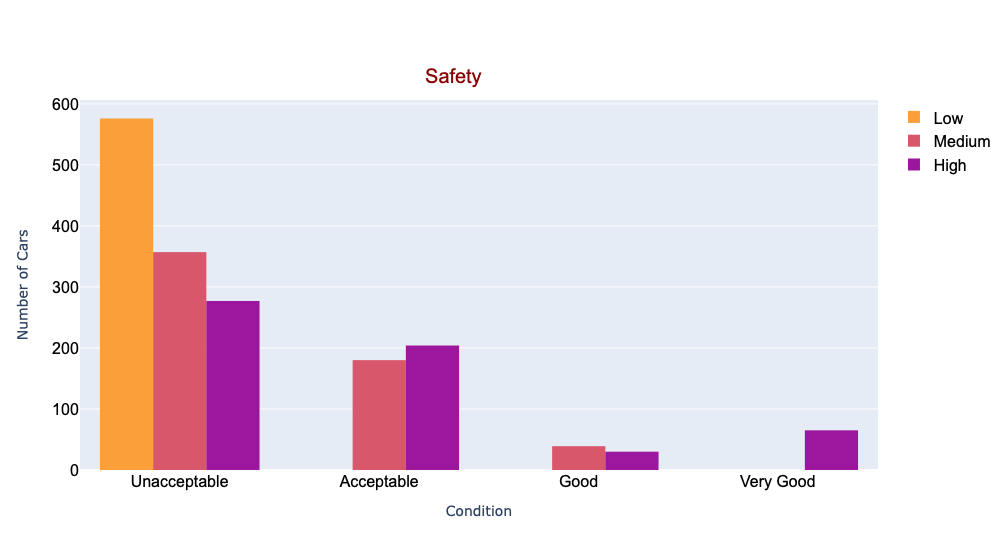

In [23]:
fg5 = go.Figure(layout=go.Layout(height=550, width=800))

fg5.add_trace(go.Histogram(x=car_df.loc[car_df.Safety=="low", "Class"],
                           name = "Low",
                           marker=dict(color="#fb9f3a")))
fg5.add_trace(go.Histogram(x=car_df.loc[car_df.Safety=="med", "Class"],
                           name = "Medium",
                           marker=dict(color="#d8576b")))
fg5.add_trace(go.Histogram(x=car_df.loc[car_df.Safety=="high", "Class"],
                           name = "High",
                           marker=dict(color="#9c179e")))

fg5.update_xaxes(title_text="Condition", 
                 showticklabels=True, 
                 tickmode="array",
                 tickvals=["unacc", "acc", "good", "vgood"],
                 ticktext=["Unacceptable", "Acceptable", "Good", "Very Good"],
                 tickfont=dict(family="Arial", size=16, color="black"))

fg5.update_yaxes(title_text="Number of Cars", tickfont=dict(family="Arial", size=16, color="black"))

fg5.update_layout(legend = dict(font = dict(family = "Arial", size = 16, color="black")),
                  title_text = 'Safety',
                  title_font = dict(size=20, family='Arial', color='darkred'),
                  title_x=0.45,
                  title_y=0.875)

fg5.show()

In [24]:
df_enc = car_df.copy()

price_map = dict({'vhigh':3,
                  'high':2,
                  'med':1,
                  'low':0})
df_enc.Price = car_df.Price.map(price_map)

maintenance_map = dict({'vhigh':3,
                        'high':2,
                        'med':1,
                        'low':0})
df_enc.Maintenance = car_df.Maintenance.map(maintenance_map)

numdoors_map = dict({'5more':3,
                     '4':2,
                     '3':1,
                     '2':0})
df_enc.NumDoors = car_df.NumDoors.map(numdoors_map)

numpersons_map = dict({'more':2,
                       '4':1,
                       '2':0})
df_enc.NumPersons = car_df.NumPersons.map(numpersons_map)

lugboot_map = dict({'big':2,
                    'med':1,
                    'small':0})
df_enc.LugBoot = car_df.LugBoot.map(lugboot_map)

safety_map = dict({'high':2,
                   'med':1,
                   'low':0})
df_enc.Safety = car_df.Safety.map(safety_map)

le = LabelEncoder()
df_enc.Class = le.fit_transform(df_enc.Class)

In [25]:
enc_class = le.fit_transform(df_enc.Class)
enc_class

array([2, 2, 2, ..., 2, 1, 3])

In [26]:
df_enc.head()

,Price,Maintenance,NumDoors,NumPersons,LugBoot,Safety,Class
0,3,3,0,0,0,0,2
1,3,3,0,0,0,1,2
2,3,3,0,0,0,2,2
3,3,3,0,0,1,0,2
4,3,3,0,0,1,1,2


In [45]:
X_car = df_enc.iloc[:,:-1]
t_car = df_enc.iloc[:,-1]

In [46]:
from sklearn.feature_selection import SelectKBest, RFE

estimator = RandomForestClassifier(max_depth=12, min_samples_split=2, max_features="log2", criterion="gini")
rfe = RFE(estimator, step=1, n_features_to_select=5)
X_car = rfe.fit_transform(X_car, t_car)
X_car.shape

(1728, 5)

In [47]:
def train_test(X, t, md=None, mss=2, mf="auto", cr="gini", msl=1):
    # KFold object instantiation
    kf = StratifiedKFold(6, shuffle=True)

    # Decision Tree Model
    model = RandomForestClassifier(n_estimators=100, max_depth=md, min_samples_split=2, max_features=mf, criterion=cr, min_samples_leaf=1)
    dt = model.fit(X, t)
    
    # Model Performance Evaluation
    mcc_scorer = make_scorer(matthews_corrcoef)
    mcc_scores = cross_val_score(model, X, t, scoring=mcc_scorer, cv=kf)
    acc_scores = cross_val_score(model, X, t, scoring="accuracy", cv=kf)
    
    mean_mcc = np.mean(mcc_scores)
    mean_acc = np.mean(acc_scores)
    
    d = dict({"Accuracy score":mean_acc,
              "MCC score":mean_mcc,
              })
  
    performance = pd.Series(d, index=d.keys())
 
    return performance

In [48]:
max_features = ['auto', 'sqrt', 'log2']

max_depth = [6, 8, 10, 12]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

crt = ["gini", "entropy"]

# Create the random grid
random_grid = {'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': crt}

In [49]:
from sklearn.model_selection import RandomizedSearchCV

dt_model = RandomForestClassifier(random_state=42)
kfd = StratifiedKFold(4, shuffle=True, random_state=1)

mcc_scorer = make_scorer(matthews_corrcoef)
dt_random = RandomizedSearchCV(estimator=dt_model, 
                               param_distributions=random_grid, 
                               n_iter = 100, 
                               scoring=mcc_scorer, 
                               cv = kfd, 
                               verbose=3,
                               n_jobs=-1,
                               random_state=42,  
                               return_train_score=True)

# Fit the random search model
dt_random.fit(X_car, t_car);

Fitting 4 folds for each of 100 candidates, totalling 400 fits


In [50]:
dt_random.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 8,
 'criterion': 'entropy'}

In [51]:
train_test(X_car, t_car, cr="gini", mf="log2", md=None, mss=2, msl=1)

Accuracy score    0.937500
MCC score         0.886237
dtype: float64